In [4]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def score_classifier(dataset,classifier,labels, boost=False):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    accuracy = 0
    precision = 0
    f1 = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        if boost:
            print(boost)
            classifier.fit(training_set,training_labels,
                           eval_set=[(test_set, test_labels)],
                           verbose=50)
        else:
            classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        # New added lines of code to plot more metrics
        accuracy += accuracy_score(test_labels, predicted_labels)
        precision += precision_score(test_labels, predicted_labels)
        f1 += f1_score(test_labels, predicted_labels)
    recall/=3
    accuracy/=3
    precision/=3
    f1/=3
    print(confusion_mat)
    cm = confusion_mat.astype(int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    disp.ax_.set_title("Confusion Matrix")
    disp.ax_.set_xlabel("Predicted Labels")
    disp.ax_.set_ylabel("True Labels")
    plt.show()
    #print(recall)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print(classification_report(test_labels,predicted_labels))
    print('\nTrue Positives(TP) = ', cm[0,0])

    print('\nTrue Negatives(TN) = ', cm[1,1])

    print('\nFalse Positives(FP) = ', cm[0,1])

    print('\nFalse Negatives(FN) = ', cm[1,0])

In [5]:
# Load dataset
df = pd.read_csv("/content/nba_logreg.csv")

In [8]:
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [9]:
df.iloc[0].values

array(['Brandon Ingram', 36, 27.4, 7.4, 2.6, 7.6, 34.7, 0.5, 2.1, 25.0,
       1.6, 2.3, 69.9, 0.7, 3.4, 4.1, 1.9, 0.4, 0.4, 1.3, 0.0],
      dtype=object)

In [10]:
df.shape

(1340, 21)

In [11]:
nan_locations = df.isna().sum()

In [12]:
nan_locations

,0
Name,0
GP,0
MIN,0
PTS,0
FGM,0
FGA,0
FG%,0
3P Made,0
3PA,0
3P%,11


In [13]:
print(df['3P%'].describe())

count    1329.000000
mean       19.308126
std        16.022916
min         0.000000
25%         0.000000
50%        22.400000
75%        32.500000
max       100.000000
Name: 3P%, dtype: float64


In [14]:
rows_with_nan = df[df.isna().any(axis=1)]
print(rows_with_nan)

               Name  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA  3P%  ...  \
338     Ken Johnson  64  12.7   4.1  1.8  3.3  52.8      0.0  0.0  NaN  ...   
339     Ken Johnson  64  12.7   4.1  1.8  3.3  52.8      0.0  0.0  NaN  ...   
340   Pete Williams  53  10.8   2.8  1.3  2.1  60.4      0.0  0.0  NaN  ...   
358   Melvin Turpin  79  24.7  10.6  4.6  9.0  51.1      0.0  0.0  NaN  ...   
386    Jim Petersen  60  11.9   3.2  1.2  2.4  48.6      0.0  0.0  NaN  ...   
397   Tom Scheffler  39   6.9   1.3  0.5  1.3  41.2      0.0  0.0  NaN  ...   
507    Sam Williams  59  18.2   6.1  2.6  4.7  55.6      0.0  0.0  NaN  ...   
509   Kurt Nimphius  63  17.2   5.3  2.2  4.7  46.1      0.0  0.0  NaN  ...   
510  Pete Verhoeven  71  17.0   4.9  2.1  4.2  50.3      0.0  0.0  NaN  ...   
521       Jim Smith  72  11.9   2.9  1.2  2.3  50.9      0.0  0.0  NaN  ...   
559    Jeff Wilkins  56  18.9   4.7  2.1  4.6  45.0      0.0  0.0  NaN  ...   

     FTA   FT%  OREB  DREB  REB  AST  STL  BLK  TOV

After visualizing different columns of the dataset, it came to my attention that only the 3P% have some missing values. These missing values are the result of division of the twwo other attributes 3P Made and 3PA. I will be changing these values to zero in order to be able to have a clean dataset for modeling.

In [7]:
df_final = df.copy()

In [8]:
df_final = df_final.fillna(0)

In [9]:
nan_locations_final = df_final.isna().sum()

In [18]:
nan_locations_final

,0
Name,0
GP,0
MIN,0
PTS,0
FGM,0
FGA,0
FG%,0
3P Made,0
3PA,0
3P%,0


Now the dataset is clean and we do not have any missing values or `NaN` values. We will be proceeding to the Data Visualization and some plots to have a more representative idea of the dataset attributes.

# Data visualization

In [19]:
# We will try first to get the number of instances of each class.
# This information is important since it will be reflected in the modeling results.
df_final['TARGET_5Yrs'].value_counts()


,count
TARGET_5Yrs,
1.0,831
0.0,509


<Axes: xlabel='TARGET_5Yrs'>

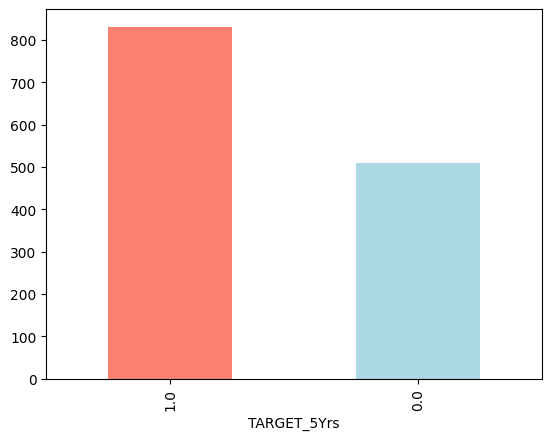

In [20]:
df_final['TARGET_5Yrs'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

#This distribution is unbalanced between the two classes of the target with Class "1" having more instances the the Class "0".
#This irregularity will be seen later in the predictions with the same pattern. The model will tend to predict the Class "1"
#more frequently than the Class "0".

In the following, I will be trying to get plot the distribtion of certain features in the dataset. It will highlight in some features won't affect as much the decision making in case there is the same value across all instances.

array([[<Axes: title={'center': 'GP'}>, <Axes: title={'center': 'MIN'}>,
        <Axes: title={'center': 'PTS'}>, <Axes: title={'center': 'FGM'}>],
       [<Axes: title={'center': 'FGA'}>, <Axes: title={'center': 'FG%'}>,
        <Axes: title={'center': '3P Made'}>,
        <Axes: title={'center': '3PA'}>],
       [<Axes: title={'center': '3P%'}>, <Axes: title={'center': 'FTM'}>,
        <Axes: title={'center': 'FTA'}>, <Axes: title={'center': 'FT%'}>],
       [<Axes: title={'center': 'OREB'}>,
        <Axes: title={'center': 'DREB'}>,
        <Axes: title={'center': 'REB'}>, <Axes: title={'center': 'AST'}>],
       [<Axes: title={'center': 'STL'}>, <Axes: title={'center': 'BLK'}>,
        <Axes: title={'center': 'TOV'}>,
        <Axes: title={'center': 'TARGET_5Yrs'}>]], dtype=object)

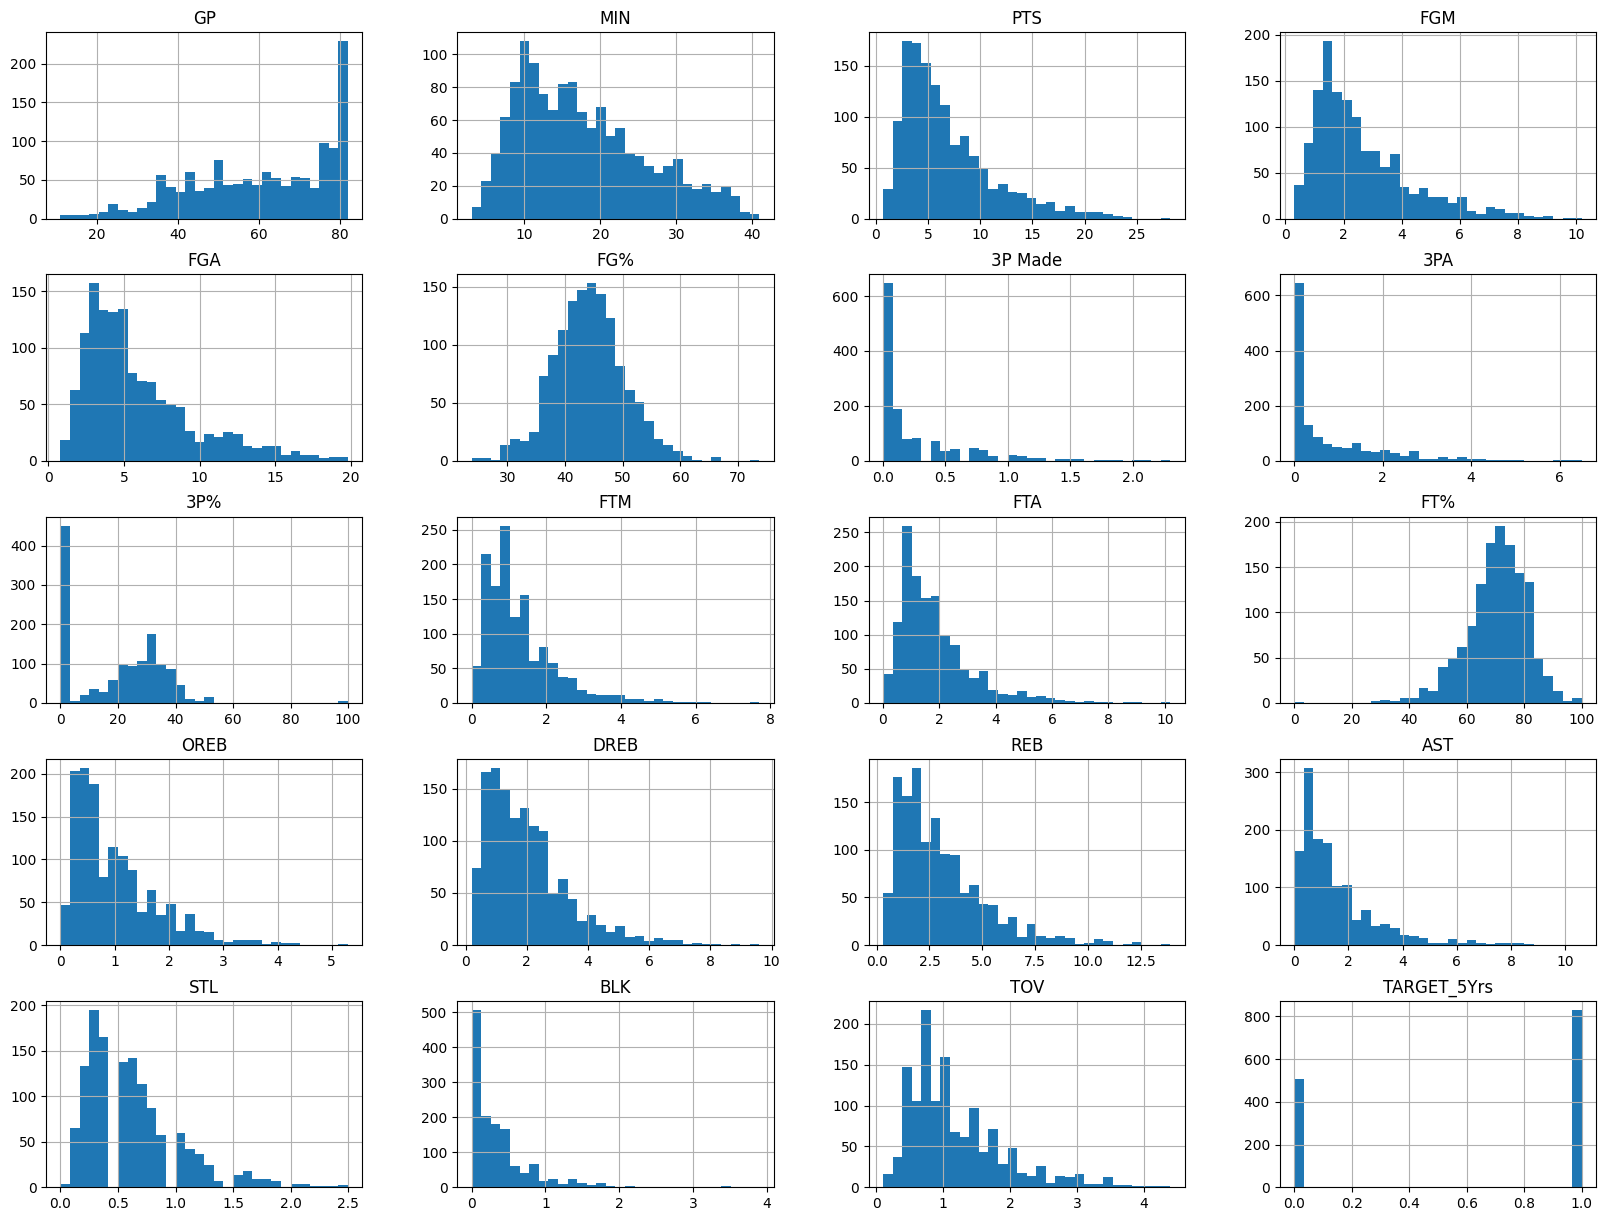

In [21]:
df_final.hist(bins=30, figsize=(20,15))

In most of features, we have a normal distribution of values with a signle peak. But all these features vary across many values and it won't be effective to delete any of them.

Another reliable way to identify the important features in a dataset can the computation of the correlation between the diffrent features and the `TRAGET_5Yrs`. This confusion matrix will give out the needed information.



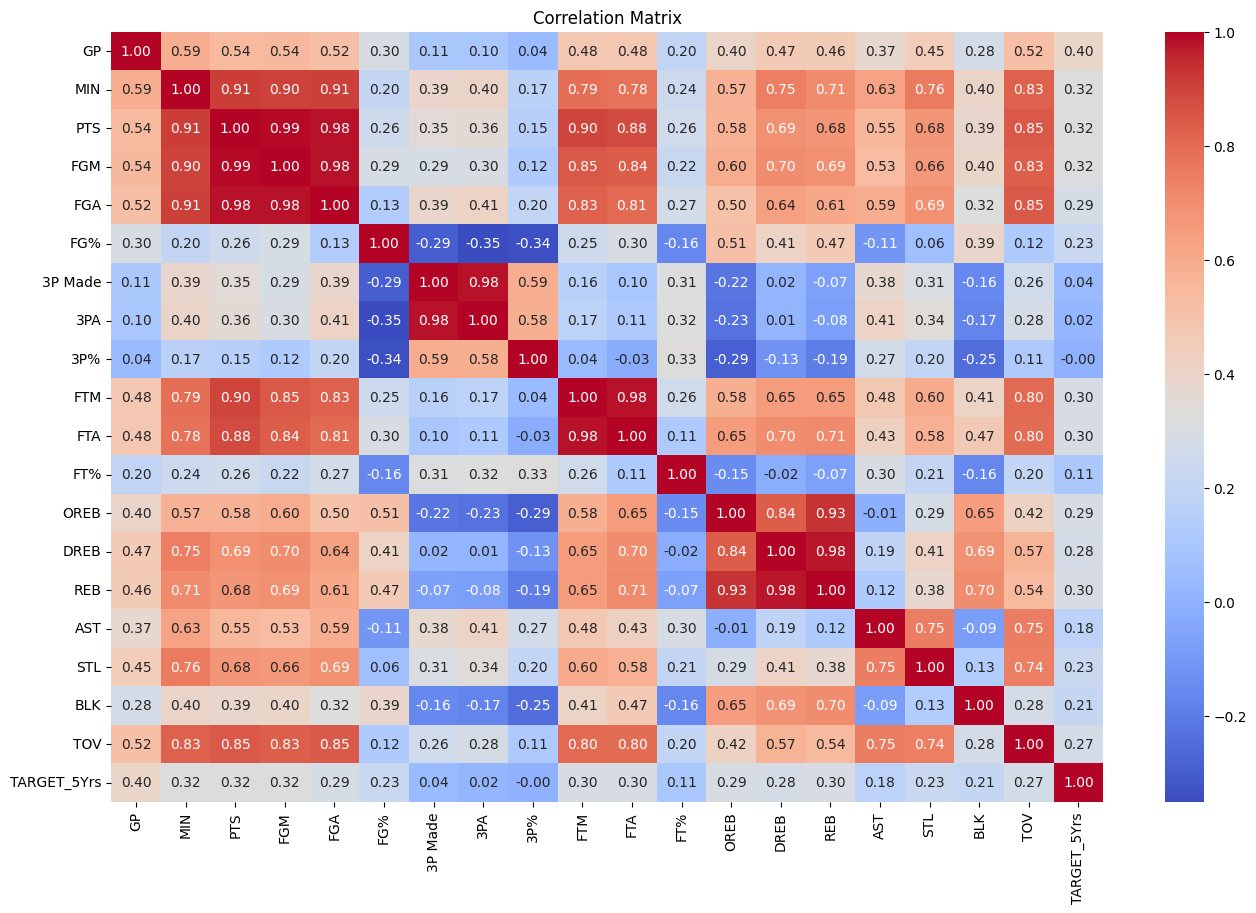

In [17]:
import seaborn as sns
# Compute correlation matrix
corr_matrix = df_final.drop(["Name"], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Comments:
* We can see from the following chart that some of the attributes and features have a high value of correlation. As we can see in the `FGM`, `FGA`, `FG%`, `3P MAde`, `3PA`, `3P%`, `FTM`, `FTA`, `FT%`. In the following part of the notebook, I will try to remove some of these variables to redundancy.

In [29]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

In [30]:
paramset

array(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV'], dtype=object)

In [31]:
df_final

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


In [25]:
df_to_use = df_final.drop(['TARGET_5Yrs','Name'],axis=1)

In [26]:
df_to_use

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3
1,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6
2,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0
3,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0
4,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,1.2,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8
1336,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,0.8,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3
1337,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,1.0,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9
1338,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,1.2,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8


In [23]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

In [27]:
# normalize dataset
X = MinMaxScaler().fit_transform(df_to_use)

[[269. 240.]
 [146. 685.]]


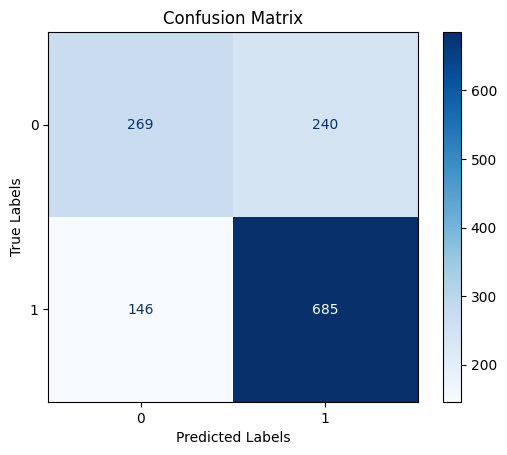

Accuracy:  0.7119511240858337
Precision:  0.7408479769528697
Recall:  0.8243162205866037
F1 Score:  0.7800738077574235
              precision    recall  f1-score   support

         0.0       0.66      0.54      0.59       164
         1.0       0.76      0.84      0.79       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.69       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  269

True Negatives(TN) =  685

False Positives(FP) =  240

False Negatives(FN) =  146


In [32]:
#example of scoring with support vector classifier
score_classifier(X,SVC(),labels)

In my study, I will be using different models and architectures to test them out and find the best performing solution. the choice of the different models is as follows:


*   **RandomforestClassifier**: the most well-known and performing model that can model the data patterns in a simple way and proven to be effective in simple clasification tabular problems.
*   **Support Vector Classifier**: has an interesting perspective to delimt the two classes using a precise kernel which can make the classification easier depending in the margin.
*   **XGBoostClassifier**: is known for its use of Boosting method that will try to improve the models sequentially. The use of XGBoost will provide some insights about the potential of boosting methods.
*   **LogisticRegression** is another simple yet effective model used for classification task
*   **CatBoostClassifier** is another boosting model, proving to be performing in classification tasks.




In [33]:
# Results with the XGBoostClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1,
                      learning_rate=0.3,
                      max_depth=10,
                    eval_metric="auc",   # 'auc' is closest to the Classification case but. we can also use 'error' or 'logloss'
                    early_stopping_rounds = 50,
                      n_estimators=500)

True
[0]	validation_0-auc:0.67479
[50]	validation_0-auc:0.70513
[55]	validation_0-auc:0.70319
True
[0]	validation_0-auc:0.67557
[50]	validation_0-auc:0.70977
[73]	validation_0-auc:0.70382
True
[0]	validation_0-auc:0.65475
[50]	validation_0-auc:0.70884
[68]	validation_0-auc:0.70901
[[261. 248.]
 [178. 653.]]


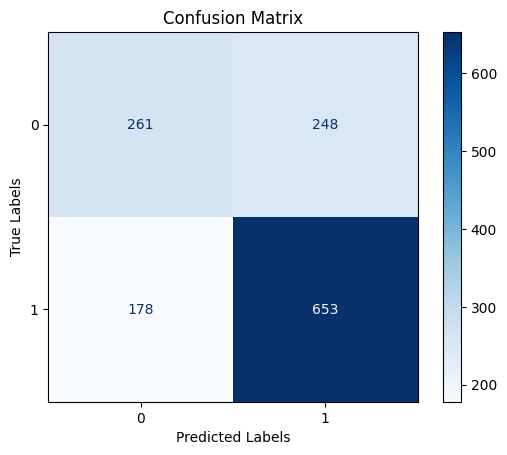

Accuracy:  0.6820942138755965
Precision:  0.7246686578119222
Recall:  0.7857326233102248
F1 Score:  0.7539615412636015
              precision    recall  f1-score   support

         0.0       0.59      0.51      0.54       164
         1.0       0.73      0.79      0.76       282

    accuracy                           0.69       446
   macro avg       0.66      0.65      0.65       446
weighted avg       0.68      0.69      0.68       446


True Positives(TP) =  261

True Negatives(TN) =  653

False Positives(FP) =  248

False Negatives(FN) =  178


In [34]:
score_classifier(X,xgb,labels, boost=True)

In [35]:
# This model will also be used in the API
joblib.dump(xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

I will be adding some graphs of feature importance to know the most important features of the dataset contributing to the decision of the `TARGET_5Yrs`.

GP: 0.133903369307518
MIN: 0.051173362880945206
PTS: 0.06642989814281464
FGM: 0.05939953029155731
FGA: 0.0446036197245121
FG%: 0.05447879433631897
3P Made: 0.03970837593078613
3PA: 0.038637738674879074
3P%: 0.0504566989839077
FTM: 0.046462081372737885
FTA: 0.04925590008497238
FT%: 0.04746915400028229
OREB: 0.055009156465530396
DREB: 0.04732351377606392
REB: 0.04901530221104622
AST: 0.04757191240787506
STL: 0.03611626848578453
BLK: 0.04462713003158569
TOV: 0.03835827484726906
    Feature  Importance
0        GP    0.133903
2       PTS    0.066430
3       FGM    0.059400
12     OREB    0.055009
5       FG%    0.054479
1       MIN    0.051173
8       3P%    0.050457
10      FTA    0.049256
14      REB    0.049015
15      AST    0.047572
11      FT%    0.047469
13     DREB    0.047324
9       FTM    0.046462
17      BLK    0.044627
4       FGA    0.044604
6   3P Made    0.039708
7       3PA    0.038638
18      TOV    0.038358
16      STL    0.036116


<ipython-input-28-0ed99f6ad71e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


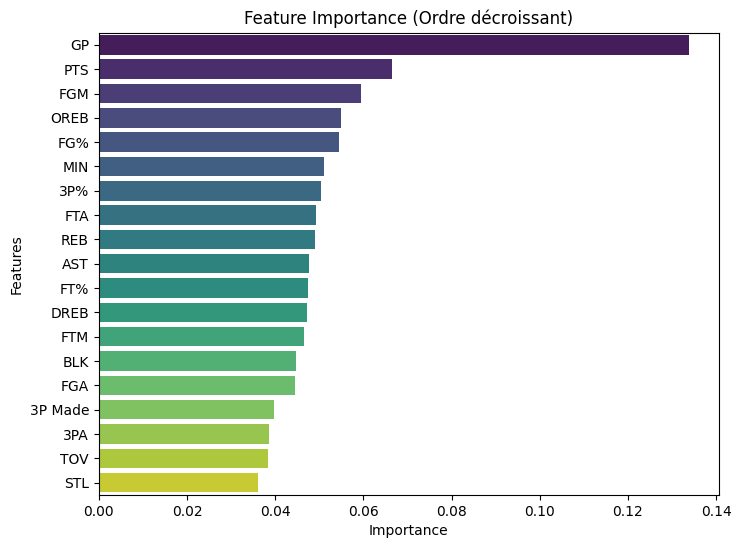

In [28]:
feature_importances = xgb.feature_importances_
for feature, importance in zip(paramset, feature_importances):
    print(f"{feature}: {importance}")

importance_df = pd.DataFrame({
    'Feature': paramset,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Ordre décroissant)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [30]:
%pip install catboost

In [31]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Precision",
    random_seed=42,
    verbose=50
)

True
0:	learn: 0.7786408	test: 0.6980392	best: 0.6980392 (0)	total: 53.6ms	remaining: 26.7s
50:	learn: 0.8347107	test: 0.6858974	best: 0.7090301 (5)	total: 223ms	remaining: 1.97s
100:	learn: 0.9058824	test: 0.6980519	best: 0.7090301 (5)	total: 442ms	remaining: 1.75s
150:	learn: 0.9568966	test: 0.7012987	best: 0.7090301 (5)	total: 807ms	remaining: 1.86s
200:	learn: 0.9875223	test: 0.7119205	best: 0.7119205 (191)	total: 1.05s	remaining: 1.57s
250:	learn: 0.9946140	test: 0.7033333	best: 0.7119205 (191)	total: 1.44s	remaining: 1.43s
300:	learn: 0.9928444	test: 0.7094595	best: 0.7123746 (271)	total: 1.84s	remaining: 1.21s
350:	learn: 0.9946140	test: 0.7070707	best: 0.7128378 (307)	total: 2.15s	remaining: 913ms
400:	learn: 0.9928444	test: 0.7023411	best: 0.7128378 (307)	total: 2.42s	remaining: 598ms
450:	learn: 0.9928444	test: 0.7100000	best: 0.7128378 (307)	total: 2.72s	remaining: 295ms
499:	learn: 0.9963964	test: 0.7066667	best: 0.7128378 (307)	total: 3.16s	remaining: 0us

bestTest = 0.712

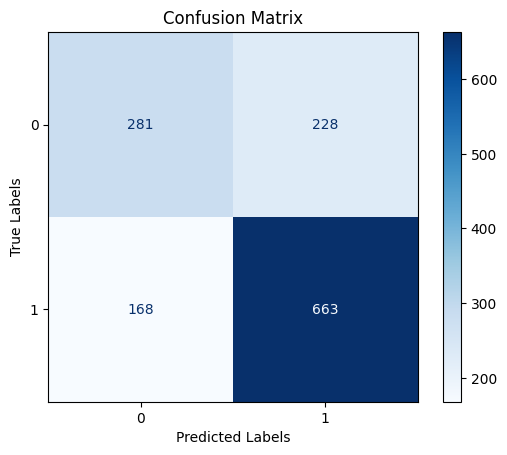

Accuracy:  0.7045040345368392
Precision:  0.7438157590596615
Recall:  0.7974447037436989
F1 Score:  0.7695863081683595
              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62       164
         1.0       0.77      0.84      0.80       282

    accuracy                           0.74       446
   macro avg       0.72      0.70      0.71       446
weighted avg       0.73      0.74      0.73       446


True Positives(TP) =  281

True Negatives(TN) =  663

False Positives(FP) =  228

False Negatives(FN) =  168


In [32]:
score_classifier(X,catboost_model,labels, boost=True)

In [33]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Recall",
    random_seed=42,
    verbose=50
)

True
0:	learn: 0.7173524	test: 0.6544118	best: 0.6544118 (0)	total: 9.06ms	remaining: 4.52s
50:	learn: 0.9033989	test: 0.7867647	best: 0.8051471 (24)	total: 408ms	remaining: 3.59s
100:	learn: 0.9642218	test: 0.7904412	best: 0.8051471 (24)	total: 804ms	remaining: 3.18s
150:	learn: 0.9928444	test: 0.7941176	best: 0.8051471 (24)	total: 1.03s	remaining: 2.38s
200:	learn: 0.9910555	test: 0.7904412	best: 0.8051471 (24)	total: 1.44s	remaining: 2.14s
250:	learn: 0.9910555	test: 0.7757353	best: 0.8051471 (24)	total: 1.81s	remaining: 1.8s
300:	learn: 0.9928444	test: 0.7720588	best: 0.8051471 (24)	total: 2.21s	remaining: 1.46s
350:	learn: 0.9910555	test: 0.7720588	best: 0.8051471 (24)	total: 2.62s	remaining: 1.11s
400:	learn: 0.9928444	test: 0.7720588	best: 0.8051471 (24)	total: 2.99s	remaining: 737ms
450:	learn: 0.9928444	test: 0.7830882	best: 0.8051471 (24)	total: 3.46s	remaining: 376ms
499:	learn: 0.9892665	test: 0.7794118	best: 0.8051471 (24)	total: 3.83s	remaining: 0us

bestTest = 0.80514705

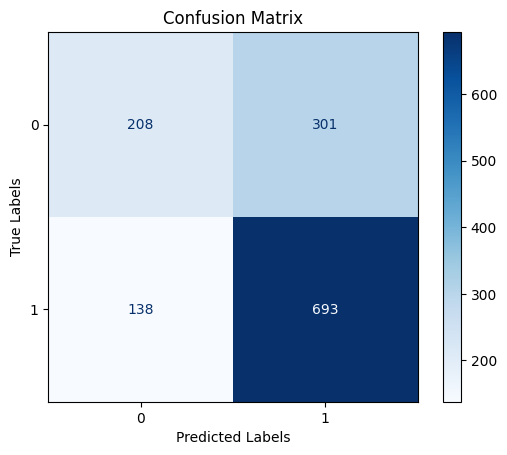

Accuracy:  0.6723915958574519
Precision:  0.6974091583240639
Recall:  0.8335947348445485
F1 Score:  0.7592254546997993
              precision    recall  f1-score   support

         0.0       0.60      0.36      0.45       164
         1.0       0.70      0.86      0.77       282

    accuracy                           0.68       446
   macro avg       0.65      0.61      0.61       446
weighted avg       0.66      0.68      0.65       446


True Positives(TP) =  208

True Negatives(TN) =  693

False Positives(FP) =  301

False Negatives(FN) =  138


In [34]:
score_classifier(X,catboost_model,labels, boost=True)

GP: 26.972821248946595
MIN: 0.0
PTS: 0.0
FGM: 12.095681459736129
FGA: 0.0
FG%: 12.718272914722844
3P Made: 0.0
3PA: 9.35737365543616
3P%: 0.0
FTM: 6.5814168632505865
FTA: 0.0
FT%: 10.539979433248233
OREB: 0.0
DREB: 10.001676934346866
REB: 4.835813892811993
AST: 0.0
STL: 6.896963597500618
BLK: 0.0
TOV: 0.0
    Feature  Importance
0        GP   26.972821
5       FG%   12.718273
3       FGM   12.095681
11      FT%   10.539979
13     DREB   10.001677
7       3PA    9.357374
16      STL    6.896964
9       FTM    6.581417
14      REB    4.835814
8       3P%    0.000000
1       MIN    0.000000
10      FTA    0.000000
6   3P Made    0.000000
12     OREB    0.000000
4       FGA    0.000000
15      AST    0.000000
2       PTS    0.000000
17      BLK    0.000000
18      TOV    0.000000


<ipython-input-35-13139fdadab6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


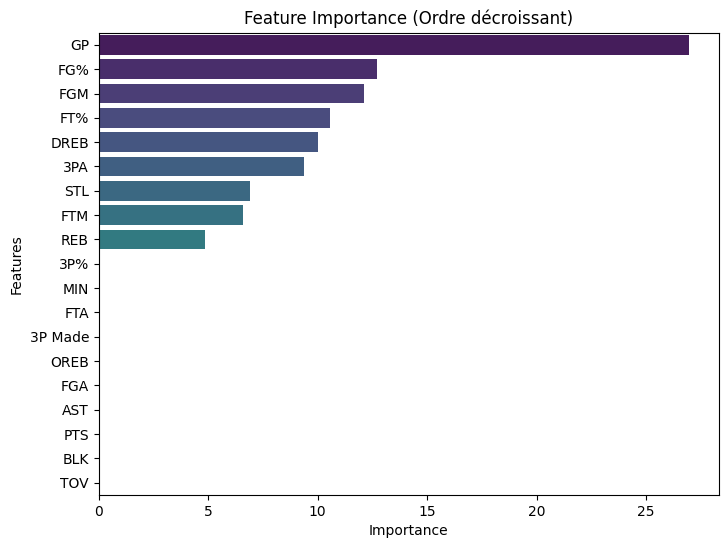

In [35]:
feature_importances = catboost_model.get_feature_importance()
for feature, importance in zip(paramset, feature_importances):
    print(f"{feature}: {importance}")

importance_df = pd.DataFrame({
    'Feature': paramset,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Ordre décroissant)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [37]:
rfc = RandomForestClassifier(n_estimators=100,
                               max_depth=20,
                               random_state=0)

[[268. 241.]
 [178. 653.]]


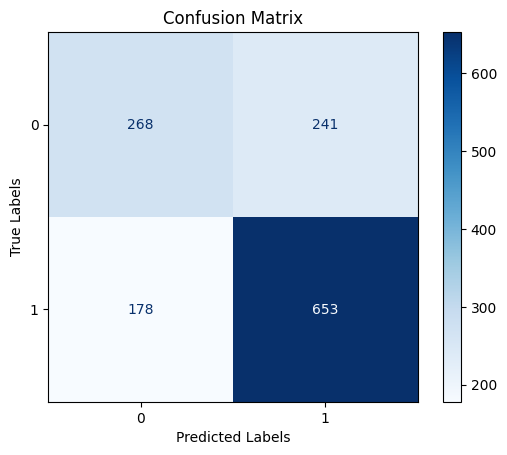

Accuracy:  0.6873292469644833
Precision:  0.7301809612733982
Recall:  0.7854932170528043
F1 Score:  0.7568101268053794
              precision    recall  f1-score   support

         0.0       0.62      0.53      0.57       164
         1.0       0.75      0.81      0.78       282

    accuracy                           0.71       446
   macro avg       0.68      0.67      0.68       446
weighted avg       0.70      0.71      0.70       446


True Positives(TP) =  268

True Negatives(TN) =  653

False Positives(FP) =  241

False Negatives(FN) =  178


In [38]:
score_classifier(X,rfc,labels)

GP: 0.10999836678475315
MIN: 0.06484091863848249
PTS: 0.06423750714695377
FGM: 0.06599961334936502
FGA: 0.051900344240904055
FG%: 0.07712796834267928
3P Made: 0.017797922295446307
3PA: 0.03859868908624811
3P%: 0.04202696970829755
FTM: 0.04161811486831148
FTA: 0.0530726504208397
FT%: 0.06435256978729918
OREB: 0.04917358962118205
DREB: 0.047054044359671095
REB: 0.05418596823589814
AST: 0.04956268206515848
STL: 0.03312216962977513
BLK: 0.03049145668013681
TOV: 0.04483845473859818
    Feature  Importance
0        GP    0.109998
5       FG%    0.077128
3       FGM    0.066000
1       MIN    0.064841
11      FT%    0.064353
2       PTS    0.064238
14      REB    0.054186
10      FTA    0.053073
4       FGA    0.051900
15      AST    0.049563
12     OREB    0.049174
13     DREB    0.047054
18      TOV    0.044838
8       3P%    0.042027
9       FTM    0.041618
7       3PA    0.038599
16      STL    0.033122
17      BLK    0.030491
6   3P Made    0.017798


<ipython-input-39-bc1a17a0bbc0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


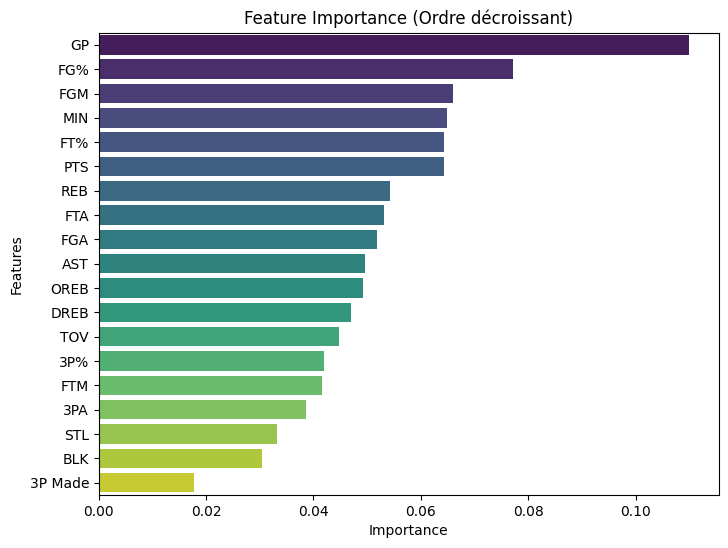

In [39]:
feature_importances = rfc.feature_importances_
for feature, importance in zip(paramset, feature_importances):
    print(f"{feature}: {importance}")

importance_df = pd.DataFrame({
    'Feature': paramset,
    'Importance': feature_importances
})

# Sorting the values
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the graph of feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Ordre décroissant)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear',
                            max_iter = 500,
                            random_state=1234)

[[261. 248.]
 [141. 690.]]


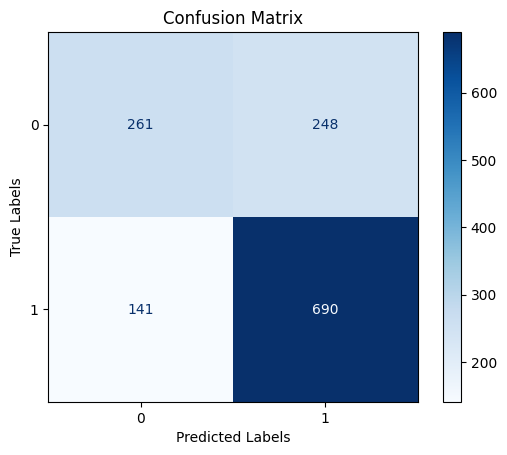

Accuracy:  0.709717331621205
Precision:  0.7358442849959373
Recall:  0.8302026964612303
F1 Score:  0.7800209227678234
              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59       164
         1.0       0.76      0.85      0.80       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.70       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  261

True Negatives(TN) =  690

False Positives(FP) =  248

False Negatives(FN) =  141


In [41]:
score_classifier(X,logreg,labels)

<ipython-input-42-f33125118d77>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


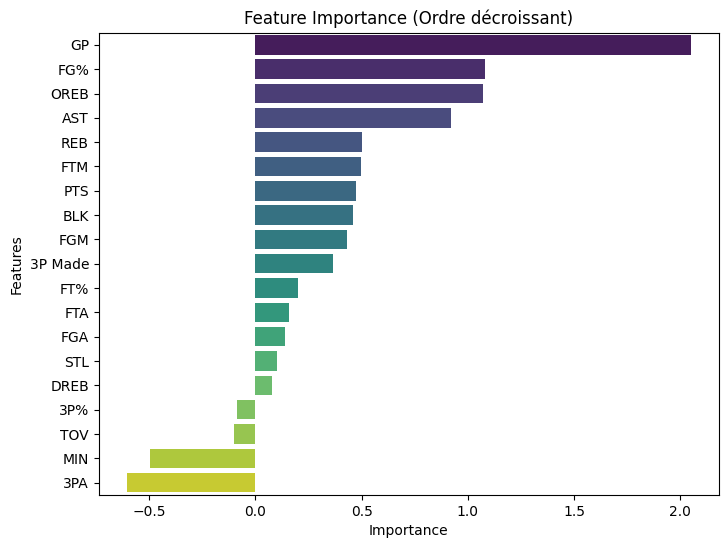

In [42]:
coefficients = logreg.coef_[0]


importance_df = pd.DataFrame({
    'Feature': paramset,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Ordre décroissant)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [43]:
# In the next part, I will be trying to test deleting the redundant data.

# Exploring dimension reduction
The following part, I will try to evaluate the first hypothesis and try to eliminate some of the attributes that may involve some redundancy. These tests are produced in 3 Parts.


1.   Delete the % attribute: `FG%`, `3P%` and `FT%`.
2.   Delete the raw data and keep only the % attribute.
3.   Keep the `FTA` and `FT%`, `FGA`, `FG%`, `3PA`, `3P%`



**First** delete the % attribute: `FG%`, `3P%` and `FT%`.

---



[[275. 234.]
 [155. 676.]]


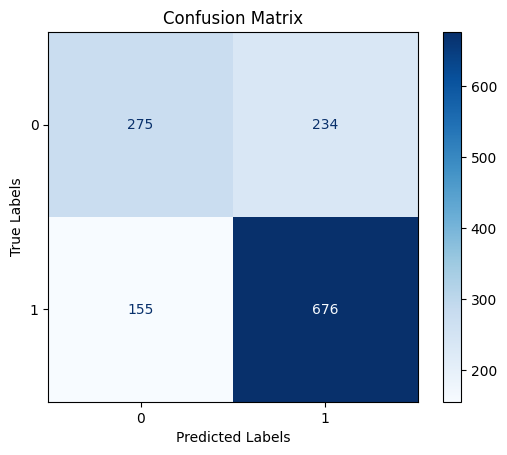

Accuracy:  0.7097156596208571
Precision:  0.7428483166811071
Recall:  0.8133737230202013
F1 Score:  0.7764359294589508
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.60       164
         1.0       0.76      0.83      0.79       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.70       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  275

True Negatives(TN) =  676

False Positives(FP) =  234

False Negatives(FN) =  155


In [44]:
df_test_1 = df_to_use.copy()
df_test_1 = df_test_1.drop(['FG%','3P%','FT%'],axis=1)
X = MinMaxScaler().fit_transform(df_test_1)
score_classifier(X,SVC(),labels)

In [45]:
xgb = XGBClassifier(random_state=1,
                      learning_rate=0.3,
                      max_depth=10,
                    eval_metric="auc",   # 'auc' is closest to the Classification case but. we can also use 'error' or 'logloss'
                    early_stopping_rounds = 100,
                      n_estimators=500)


True
[0]	validation_0-auc:0.64848
[50]	validation_0-auc:0.67511
[100]	validation_0-auc:0.67525
[121]	validation_0-auc:0.67422
True
[0]	validation_0-auc:0.63475
[50]	validation_0-auc:0.69749
[100]	validation_0-auc:0.69577
[113]	validation_0-auc:0.69635
True
[0]	validation_0-auc:0.63581
[50]	validation_0-auc:0.69111
[100]	validation_0-auc:0.68694
[117]	validation_0-auc:0.68573
[[261. 248.]
 [205. 626.]]


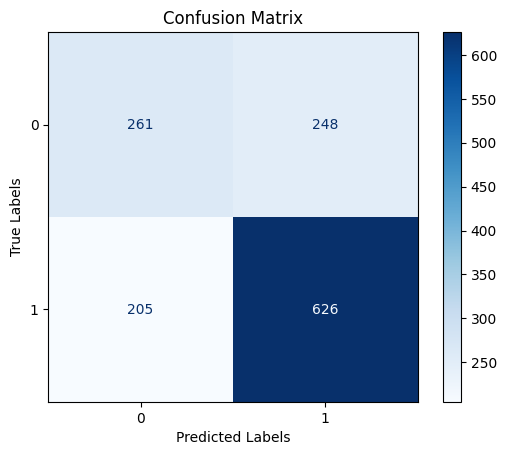

Accuracy:  0.6619432656841993
Precision:  0.7162118804548091
Recall:  0.7532993822000726
F1 Score:  0.7342670993208724
              precision    recall  f1-score   support

         0.0       0.55      0.51      0.53       164
         1.0       0.73      0.76      0.74       282

    accuracy                           0.67       446
   macro avg       0.64      0.63      0.64       446
weighted avg       0.66      0.67      0.66       446


True Positives(TP) =  261

True Negatives(TN) =  626

False Positives(FP) =  248

False Negatives(FN) =  205


In [46]:
score_classifier(X,xgb,labels, boost=True)

True
0:	learn: 0.8246869	test: 0.8198529	best: 0.8198529 (0)	total: 2.55ms	remaining: 1.27s
50:	learn: 0.8908766	test: 0.7867647	best: 0.8419118 (1)	total: 410ms	remaining: 3.61s
100:	learn: 0.9516995	test: 0.7720588	best: 0.8419118 (1)	total: 800ms	remaining: 3.16s
150:	learn: 0.9838998	test: 0.7683824	best: 0.8419118 (1)	total: 994ms	remaining: 2.3s
200:	learn: 0.9928444	test: 0.7610294	best: 0.8419118 (1)	total: 1.33s	remaining: 1.98s
250:	learn: 0.9910555	test: 0.7463235	best: 0.8419118 (1)	total: 1.67s	remaining: 1.65s
300:	learn: 0.9910555	test: 0.7463235	best: 0.8419118 (1)	total: 2.07s	remaining: 1.37s
350:	learn: 0.9928444	test: 0.7500000	best: 0.8419118 (1)	total: 2.44s	remaining: 1.04s
400:	learn: 0.9928444	test: 0.7500000	best: 0.8419118 (1)	total: 2.75s	remaining: 679ms
450:	learn: 0.9910555	test: 0.7463235	best: 0.8419118 (1)	total: 3.19s	remaining: 347ms
499:	learn: 0.9928444	test: 0.7500000	best: 0.8419118 (1)	total: 3.81s	remaining: 0us

bestTest = 0.8419117647
bestIte

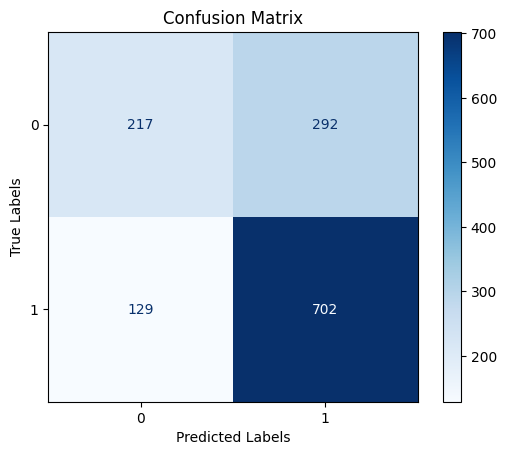

Accuracy:  0.6858595586587882
Precision:  0.7096861872992339
Recall:  0.8449023034207922
F1 Score:  0.7698928615707459
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63       164
         1.0       0.78      0.82      0.80       282

    accuracy                           0.74       446
   macro avg       0.72      0.71      0.71       446
weighted avg       0.73      0.74      0.73       446


True Positives(TP) =  217

True Negatives(TN) =  702

False Positives(FP) =  292

False Negatives(FN) =  129


In [47]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Recall",
    random_seed=42,
    verbose=50
)
score_classifier(X,catboost_model,labels, boost=True)

[[268. 241.]
 [184. 647.]]


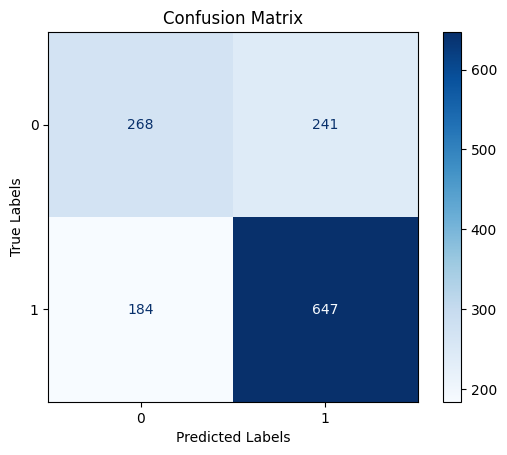

Accuracy:  0.6828466140320958
Precision:  0.7285326737690143
Recall:  0.7784231392329058
F1 Score:  0.7526318297154121
              precision    recall  f1-score   support

         0.0       0.60      0.54      0.57       164
         1.0       0.75      0.79      0.77       282

    accuracy                           0.70       446
   macro avg       0.67      0.66      0.67       446
weighted avg       0.69      0.70      0.69       446


True Positives(TP) =  268

True Negatives(TN) =  647

False Positives(FP) =  241

False Negatives(FN) =  184


In [48]:
rfc = RandomForestClassifier(n_estimators=100,
                               max_depth=20,
                               random_state=0)
score_classifier(X,rfc,labels)

[[265. 244.]
 [141. 690.]]


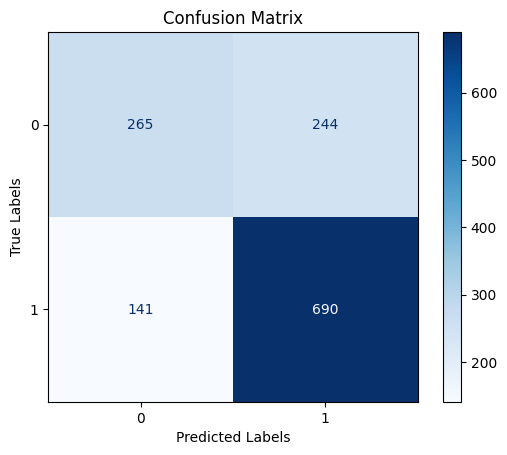

Accuracy:  0.7127001802416375
Precision:  0.7390059116101817
Recall:  0.8302674898978717
F1 Score:  0.7818309508732216
              precision    recall  f1-score   support

         0.0       0.66      0.54      0.60       164
         1.0       0.76      0.84      0.80       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.70       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  265

True Negatives(TN) =  690

False Positives(FP) =  244

False Negatives(FN) =  141


In [49]:
logreg = LogisticRegression(solver='liblinear',
                            max_iter = 500,
                            random_state=1234)
score_classifier(X,logreg,labels)

In the **second** test, delete the raw data and keep only the % attribute.


---



[[260. 249.]
 [142. 689.]]


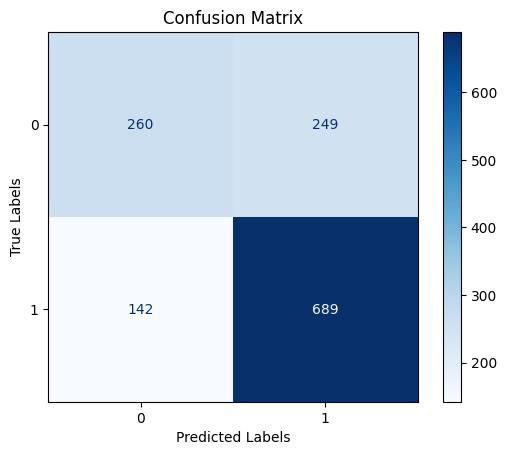

Accuracy:  0.7082208913099454
Precision:  0.7349268289080141
Recall:  0.8292181813709174
F1 Score:  0.778852718158984
              precision    recall  f1-score   support

         0.0       0.65      0.53      0.59       164
         1.0       0.75      0.84      0.79       282

    accuracy                           0.72       446
   macro avg       0.70      0.68      0.69       446
weighted avg       0.72      0.72      0.72       446


True Positives(TP) =  260

True Negatives(TN) =  689

False Positives(FP) =  249

False Negatives(FN) =  142


In [50]:
df_test_2 = df_to_use.copy()
df_test_2 = df_test_2.drop(['FTM','FTA','3P Made', '3PA', 'FGM', 'FGA'],axis=1)
X = MinMaxScaler().fit_transform(df_test_2)
score_classifier(X,SVC(),labels)

True
[0]	validation_0-auc:0.68358
[50]	validation_0-auc:0.69660
[73]	validation_0-auc:0.69842
True
[0]	validation_0-auc:0.68851
[50]	validation_0-auc:0.70406
[60]	validation_0-auc:0.70265
True
[0]	validation_0-auc:0.67858
[50]	validation_0-auc:0.70504
[59]	validation_0-auc:0.70670
[[265. 244.]
 [185. 646.]]


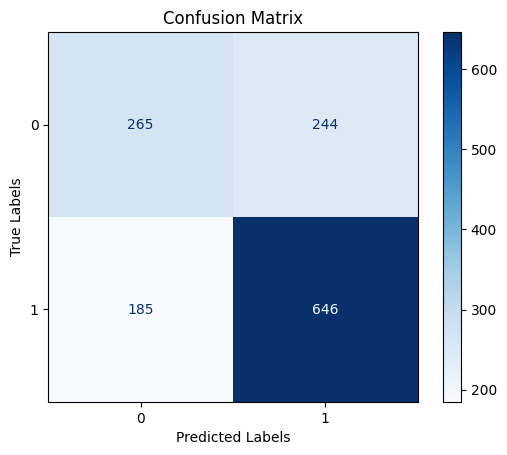

Accuracy:  0.6798620934113154
Precision:  0.7259260280688852
Recall:  0.7773509255201172
F1 Score:  0.7506747227567253
              precision    recall  f1-score   support

         0.0       0.59      0.54      0.57       164
         1.0       0.75      0.78      0.76       282

    accuracy                           0.70       446
   macro avg       0.67      0.66      0.67       446
weighted avg       0.69      0.70      0.69       446


True Positives(TP) =  265

True Negatives(TN) =  646

False Positives(FP) =  244

False Negatives(FN) =  185


In [51]:
xgb = XGBClassifier(random_state=1,
                      learning_rate=0.3,
                      max_depth=10,
                    eval_metric="auc",   # 'auc' is closest to the Classification case but. we can also use 'error' or 'logloss'
                    early_stopping_rounds = 50,
                      n_estimators=500)
score_classifier(X,xgb,labels, boost=True)

True
0:	learn: 0.8425760	test: 0.8125000	best: 0.8125000 (0)	total: 2.58ms	remaining: 1.29s
50:	learn: 0.8980322	test: 0.8198529	best: 0.8272059 (2)	total: 127ms	remaining: 1.12s
100:	learn: 0.9534884	test: 0.7977941	best: 0.8272059 (2)	total: 250ms	remaining: 989ms
150:	learn: 0.9874776	test: 0.7867647	best: 0.8272059 (2)	total: 379ms	remaining: 875ms
200:	learn: 0.9910555	test: 0.7830882	best: 0.8272059 (2)	total: 503ms	remaining: 748ms
250:	learn: 0.9910555	test: 0.7757353	best: 0.8272059 (2)	total: 624ms	remaining: 619ms
300:	learn: 0.9910555	test: 0.7610294	best: 0.8272059 (2)	total: 741ms	remaining: 490ms
350:	learn: 0.9910555	test: 0.7757353	best: 0.8272059 (2)	total: 891ms	remaining: 378ms
400:	learn: 0.9910555	test: 0.7794118	best: 0.8272059 (2)	total: 1.01s	remaining: 249ms
450:	learn: 0.9910555	test: 0.7720588	best: 0.8272059 (2)	total: 1.13s	remaining: 123ms
499:	learn: 0.9928444	test: 0.7720588	best: 0.8272059 (2)	total: 1.26s	remaining: 0us

bestTest = 0.8272058824
bestIt

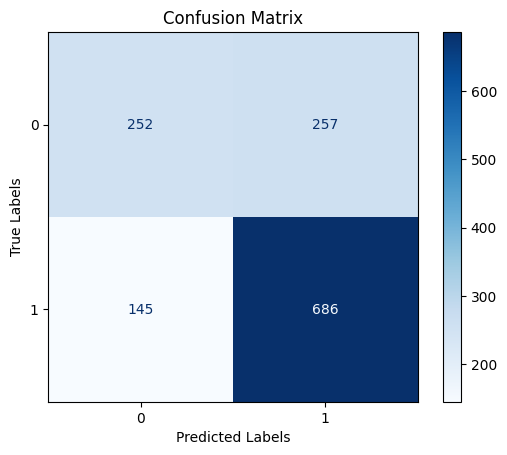

Accuracy:  0.7000013376002783
Precision:  0.7283824101245521
Recall:  0.8254318913985442
F1 Score:  0.7734696417708338
              precision    recall  f1-score   support

         0.0       0.63      0.46      0.53       164
         1.0       0.73      0.84      0.78       282

    accuracy                           0.70       446
   macro avg       0.68      0.65      0.66       446
weighted avg       0.69      0.70      0.69       446


True Positives(TP) =  252

True Negatives(TN) =  686

False Positives(FP) =  257

False Negatives(FN) =  145


In [52]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Recall",
    random_seed=42,
    verbose=50
)
score_classifier(X,catboost_model,labels, boost=True)

[[268. 241.]
 [177. 654.]]


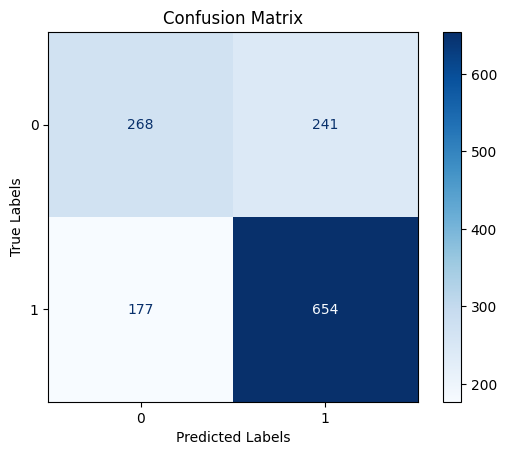

Accuracy:  0.6880849911216781
Precision:  0.7302497171554383
Recall:  0.7865440944281032
F1 Score:  0.7573466681258214
              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59       164
         1.0       0.76      0.82      0.79       282

    accuracy                           0.72       446
   macro avg       0.70      0.69      0.69       446
weighted avg       0.72      0.72      0.72       446


True Positives(TP) =  268

True Negatives(TN) =  654

False Positives(FP) =  241

False Negatives(FN) =  177


In [53]:
rfc = RandomForestClassifier(n_estimators=100,
                               max_depth=20,
                               random_state=0)
score_classifier(X,rfc,labels)

[[262. 247.]
 [141. 690.]]


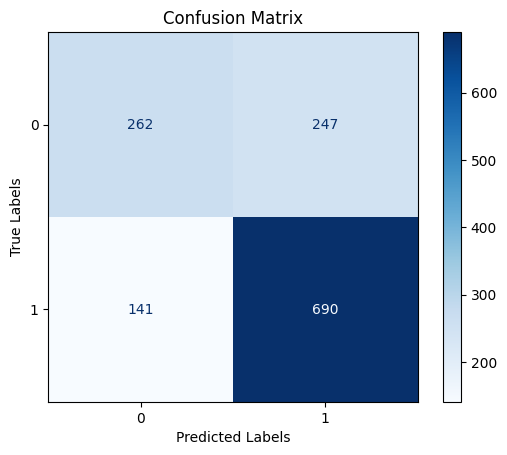

Accuracy:  0.7104596997756175
Precision:  0.7366576258887375
Recall:  0.8302461535603821
F1 Score:  0.780482780199184
              precision    recall  f1-score   support

         0.0       0.66      0.52      0.59       164
         1.0       0.75      0.84      0.80       282

    accuracy                           0.73       446
   macro avg       0.71      0.68      0.69       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  262

True Negatives(TN) =  690

False Positives(FP) =  247

False Negatives(FN) =  141


In [54]:
logreg = LogisticRegression(solver='liblinear',
                            max_iter = 500,
                            random_state=1234)
score_classifier(X,logreg,labels)

In the **third** test, I will be keeping the `FTA` and `FT%`, `FGA`, `FG%`, `3PA`, `3P%`.


---



[[271. 238.]
 [157. 674.]]


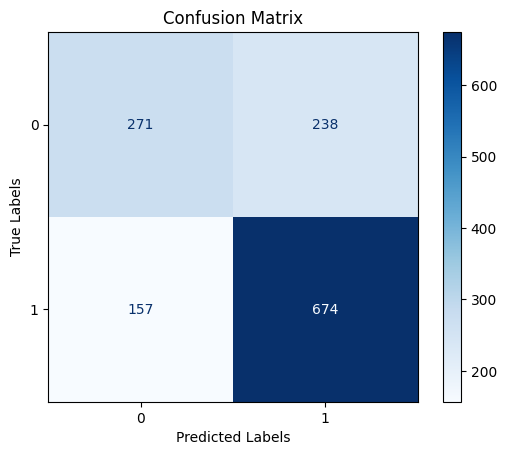

Accuracy:  0.705236370689165
Precision:  0.7390583784435388
Recall:  0.8109867516405133
F1 Score:  0.7733028281229104
              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59       164
         1.0       0.76      0.82      0.79       282

    accuracy                           0.72       446
   macro avg       0.70      0.69      0.69       446
weighted avg       0.72      0.72      0.72       446


True Positives(TP) =  271

True Negatives(TN) =  674

False Positives(FP) =  238

False Negatives(FN) =  157


In [55]:
df_test_3 = df_to_use.copy()
df_test_3 = df_test_1.drop(['FTM','3P Made', 'FGM'],axis=1)
X = MinMaxScaler().fit_transform(df_test_3)
score_classifier(X,SVC(),labels)

True
[0]	validation_0-auc:0.64652
[50]	validation_0-auc:0.67006
[70]	validation_0-auc:0.66601
True
[0]	validation_0-auc:0.66396
[50]	validation_0-auc:0.69131
[51]	validation_0-auc:0.69146
True
[0]	validation_0-auc:0.61537
[50]	validation_0-auc:0.69397
[54]	validation_0-auc:0.69334
[[249. 260.]
 [182. 649.]]


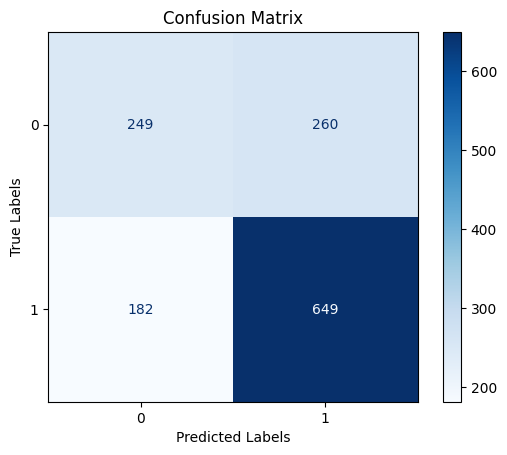

Accuracy:  0.6701611473935186
Precision:  0.7143847793106333
Recall:  0.780958680550849
F1 Score:  0.7459175084175085
              precision    recall  f1-score   support

         0.0       0.58      0.54      0.56       164
         1.0       0.74      0.77      0.76       282

    accuracy                           0.69       446
   macro avg       0.66      0.65      0.66       446
weighted avg       0.68      0.69      0.68       446


True Positives(TP) =  249

True Negatives(TN) =  649

False Positives(FP) =  260

False Negatives(FN) =  182


In [56]:
xgb = XGBClassifier(random_state=1,
                      learning_rate=0.3,
                      max_depth=10,
                    eval_metric="auc",   # 'auc' is closest to the Classification case but. we can also use 'error' or 'logloss'
                    early_stopping_rounds = 50,
                      n_estimators=500)
score_classifier(X,xgb,labels, boost=True)

True
0:	learn: 0.7889088	test: 0.7610294	best: 0.7610294 (0)	total: 5.51ms	remaining: 2.75s
50:	learn: 0.8837209	test: 0.7757353	best: 0.8088235 (2)	total: 299ms	remaining: 2.63s
100:	learn: 0.9606440	test: 0.7904412	best: 0.8088235 (2)	total: 568ms	remaining: 2.24s
150:	learn: 0.9838998	test: 0.7867647	best: 0.8088235 (2)	total: 685ms	remaining: 1.58s
200:	learn: 0.9928444	test: 0.7830882	best: 0.8088235 (2)	total: 777ms	remaining: 1.16s
250:	learn: 0.9928444	test: 0.7830882	best: 0.8088235 (2)	total: 867ms	remaining: 860ms
300:	learn: 0.9928444	test: 0.7867647	best: 0.8088235 (2)	total: 960ms	remaining: 635ms
350:	learn: 0.9910555	test: 0.7794118	best: 0.8088235 (2)	total: 1.05s	remaining: 446ms
400:	learn: 0.9928444	test: 0.7720588	best: 0.8088235 (2)	total: 1.14s	remaining: 282ms
450:	learn: 0.9946333	test: 0.7794118	best: 0.8088235 (2)	total: 1.24s	remaining: 134ms
499:	learn: 0.9946333	test: 0.7830882	best: 0.8088235 (2)	total: 1.33s	remaining: 0us

bestTest = 0.8088235294
bestIt

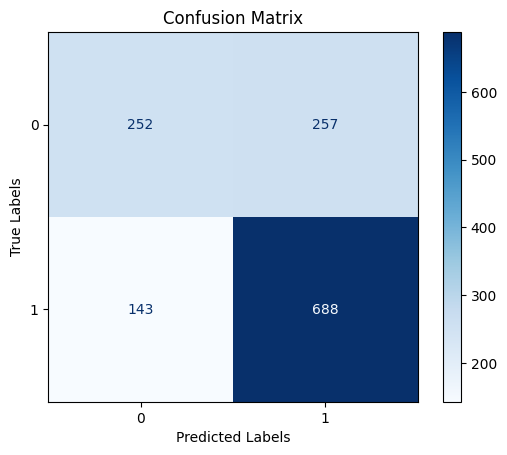

Accuracy:  0.7015044659129289
Precision:  0.72809071610248
Recall:  0.8276000084341287
F1 Score:  0.7744854905781452
              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55       164
         1.0       0.74      0.86      0.79       282

    accuracy                           0.72       446
   macro avg       0.70      0.67      0.67       446
weighted avg       0.71      0.72      0.70       446


True Positives(TP) =  252

True Negatives(TN) =  688

False Positives(FP) =  257

False Negatives(FN) =  143


In [57]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Recall",
    random_seed=42,
    verbose=50
)
score_classifier(X,catboost_model,labels, boost=True)

[[271. 238.]
 [183. 648.]]


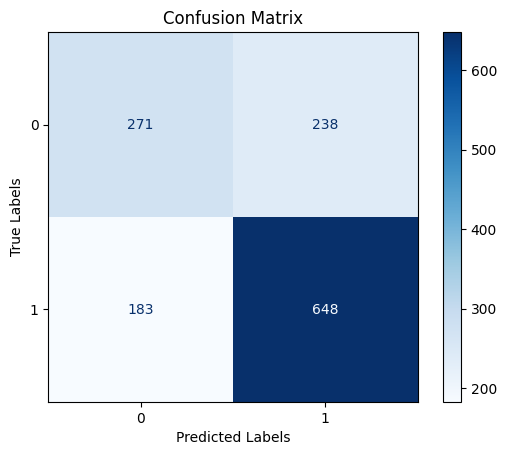

Accuracy:  0.6858261186518327
Precision:  0.7313517200522851
Recall:  0.7797347592031154
F1 Score:  0.754732114277418
              precision    recall  f1-score   support

         0.0       0.59      0.54      0.57       164
         1.0       0.75      0.78      0.76       282

    accuracy                           0.69       446
   macro avg       0.67      0.66      0.66       446
weighted avg       0.69      0.69      0.69       446


True Positives(TP) =  271

True Negatives(TN) =  648

False Positives(FP) =  238

False Negatives(FN) =  183


In [58]:
rfc = RandomForestClassifier(n_estimators=100,
                               max_depth=20,
                               random_state=0)
score_classifier(X,rfc,labels)

[[261. 248.]
 [145. 686.]]


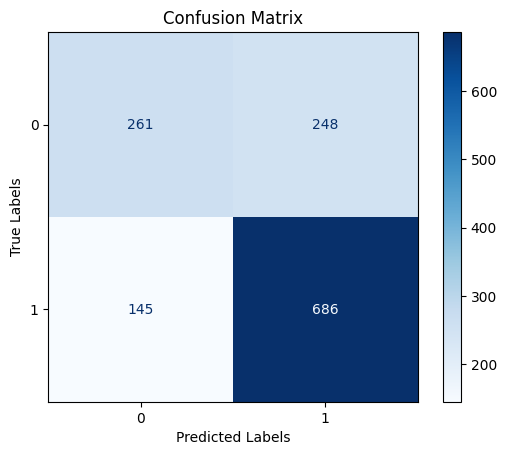

Accuracy:  0.7067311390000769
Precision:  0.7347558149895642
Recall:  0.825365529113558
F1 Score:  0.777293556022777
              precision    recall  f1-score   support

         0.0       0.66      0.53      0.59       164
         1.0       0.75      0.84      0.80       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.69       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  261

True Negatives(TN) =  686

False Positives(FP) =  248

False Negatives(FN) =  145


In [59]:
logreg = LogisticRegression(solver='liblinear',
                            max_iter = 500,
                            random_state=1234)
score_classifier(X,logreg,labels)

**Conclusion**:
Deleting several features from the dataset did not have much of an improvement in the results. The best approach is to keep all the features in the training phase to have the most information available for the model.

# Hyperparameter Tuning
In the next part, we will doing some **hyperparameter tuning** in order to get the best parameters of each model.

In [60]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Fitting the GridSearch to look for the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X, labels)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_model_rf = grid_search.best_estimator_
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.6902985074626866


[[266. 243.]
 [180. 651.]]


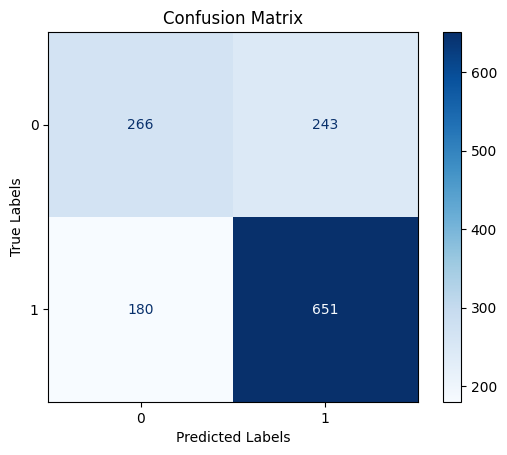

Accuracy:  0.6843330223412686
Precision:  0.7285042347247429
Recall:  0.7835194803271438
F1 Score:  0.7547892744491532
              precision    recall  f1-score   support

         0.0       0.58      0.55      0.57       164
         1.0       0.75      0.77      0.76       282

    accuracy                           0.69       446
   macro avg       0.67      0.66      0.66       446
weighted avg       0.69      0.69      0.69       446


True Positives(TP) =  266

True Negatives(TN) =  651

False Positives(FP) =  243

False Negatives(FN) =  180


In [61]:
score_classifier(X,best_model_rf,labels)

Comments on the results: No improvement is witnessed in the results of Hyperparameter Tuning for RandomForestClassifier

In [62]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [63]:
import sklearn
print(sklearn.__version__)

1.5.2


In [65]:
import xgboost
import sklearn
print(xgboost.__version__)
print(sklearn.__version__)

2.1.3
1.5.2


In [66]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
xgb_model = XGBClassifier(random_state=42, verbosity=0)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10]
}

# Fit the model
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# create the model with best params
best_model_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 10, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.9108048813931168


True
[0]	validation_0-logloss:0.66911
[50]	validation_0-logloss:0.63283
[99]	validation_0-logloss:0.61610
True
[0]	validation_0-logloss:0.66332
[50]	validation_0-logloss:0.62218
[99]	validation_0-logloss:0.60032
True
[0]	validation_0-logloss:0.65766
[50]	validation_0-logloss:0.61885
[99]	validation_0-logloss:0.59757
[[131. 378.]
 [ 72. 759.]]


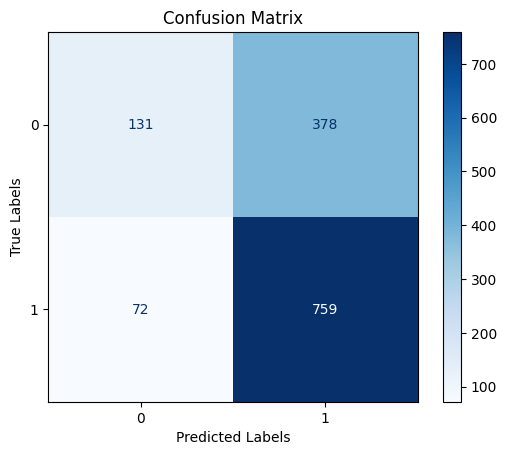

Accuracy:  0.6641937781523058
Precision:  0.6673075332761197
Recall:  0.9130549267611389
F1 Score:  0.7710679993913102
              precision    recall  f1-score   support

         0.0       0.69      0.26      0.37       164
         1.0       0.68      0.93      0.79       282

    accuracy                           0.68       446
   macro avg       0.69      0.59      0.58       446
weighted avg       0.69      0.68      0.64       446


True Positives(TP) =  131

True Negatives(TN) =  759

False Positives(FP) =  378

False Negatives(FN) =  72


In [67]:
score_classifier(X,best_model_xgb,labels, boost=True)

Comments on the results: XGBoost is the best performing model with over 90% of recall.

In [68]:
# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(
    verbose=0,  # Suppress output
    random_state=42
)

# Define the parameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'subsample': [0.6, 0.8, 1.0]
}

# Fit the model
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Recall:", grid_search.best_score_)

best_model_cat = grid_search.best_estimator_

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'border_count': 64, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'subsample': 0.6}
Best Cross-Validation Recall: 0.8217057452351569


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


True
0:	learn: 0.6908857	test: 0.6913281	best: 0.6913281 (0)	total: 1.07ms	remaining: 106ms
50:	learn: 0.6164878	test: 0.6372982	best: 0.6372982 (50)	total: 34.1ms	remaining: 32.8ms
99:	learn: 0.5802193	test: 0.6163568	best: 0.6163568 (99)	total: 60ms	remaining: 0us

bestTest = 0.6163567848
bestIteration = 99

True
0:	learn: 0.6911489	test: 0.6914668	best: 0.6914668 (0)	total: 745us	remaining: 73.8ms
50:	learn: 0.6248505	test: 0.6305694	best: 0.6305694 (50)	total: 31.5ms	remaining: 30.3ms
99:	learn: 0.5918161	test: 0.6020030	best: 0.6020030 (99)	total: 60.2ms	remaining: 0us

bestTest = 0.60200301
bestIteration = 99

True
0:	learn: 0.6913620	test: 0.6913269	best: 0.6913269 (0)	total: 799us	remaining: 79.2ms
50:	learn: 0.6315373	test: 0.6278903	best: 0.6278903 (50)	total: 30.4ms	remaining: 29.2ms
99:	learn: 0.6009478	test: 0.5967022	best: 0.5967022 (99)	total: 55.6ms	remaining: 0us

bestTest = 0.5967021669
bestIteration = 99

[[279. 230.]
 [163. 668.]]


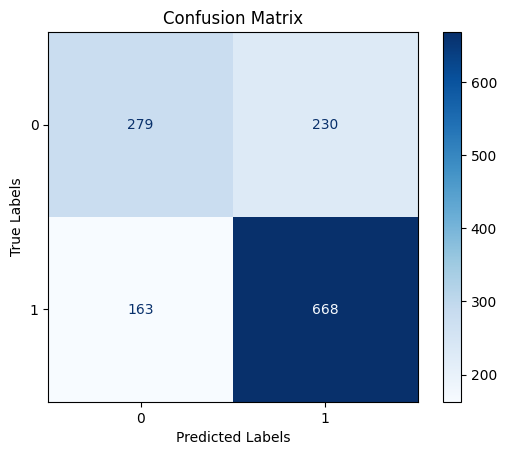

Accuracy:  0.7067311390000769
Precision:  0.7444832944832944
Recall:  0.8038542336564909
F1 Score:  0.7726566396949427
              precision    recall  f1-score   support

         0.0       0.64      0.57      0.61       164
         1.0       0.77      0.82      0.79       282

    accuracy                           0.73       446
   macro avg       0.71      0.69      0.70       446
weighted avg       0.72      0.73      0.72       446


True Positives(TP) =  279

True Negatives(TN) =  668

False Positives(FP) =  230

False Negatives(FN) =  163


In [69]:
score_classifier(X,best_model_cat,labels, boost=True)

Comment on the results: small improvement was witnessed in the recall.

In [70]:
import joblib

# Save the model to a pickle file. This model can be used later for the Second Question for the API
joblib.dump(best_model_cat, 'model_cat_best.pkl')

['model_cat_best.pkl']

In [71]:
log_reg = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

# Define the hyperparameter
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7]
}

# Fit the model
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Recall:", grid_search.best_score_)

log_reg_best_model = grid_search.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'C': 0.01, 'l1_ratio': 0.1}
Best Cross-Validation Recall: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[[  0. 509.]
 [  0. 831.]]


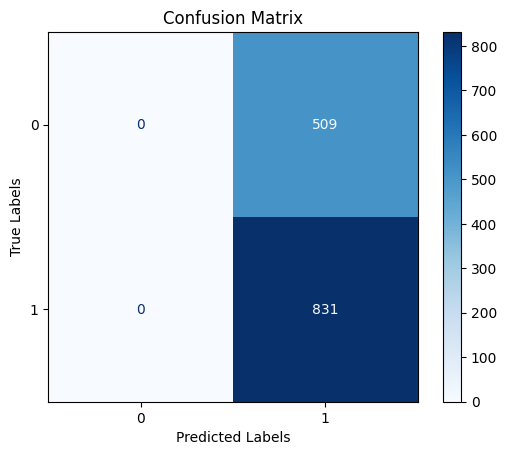

Accuracy:  0.6201583049929275
Precision:  0.6201583049929275
Recall:  1.0
F1 Score:  0.7655083475552359
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       164
         1.0       0.63      1.00      0.77       282

    accuracy                           0.63       446
   macro avg       0.32      0.50      0.39       446
weighted avg       0.40      0.63      0.49       446


True Positives(TP) =  0

True Negatives(TN) =  831

False Positives(FP) =  509

False Negatives(FN) =  0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
score_classifier(X,log_reg_best_model,labels)

The model overfitted to the Class 1 and can no longer predict the Class 0

Next steps for the modeling part of the test:


1.   Use a more sophisticated dimension reduction approach in the future like the PCA. It is usually a great solution if we have an obscene amount of data and the feature selection gives insights about some irrelevant features.
2.   For the NaN Values in the 3P%, fill the NaN values with -1 instead of 0. This way the model will know that these players should be penalized for not attempting the 3 Points.



# **Question 2**

In [1]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
from threading import Thread


app = Flask(__name__)


@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the data from JSON File
        data = request.json
        best_model = joblib.load('xgboost_model.pkl')
        # Features of the model
        features = np.array([data['GP'], data['MIN'], data['PTS'],
                             data['FGM'], data['FGA'], data['FG%'],
                             data['3P Made'], data['3PA'], data['3P%'],
                             data['FTM'], data['FTA'], data['FT%'],
                             data['OREB'], data['DREB'], data['REB'],
                             data['AST'], data['STL'], data['BLK'], data['TOV']
                             ]
                            )
        # Predict with the chosen model
        prediction = best_model.predict([features])[0]
        return jsonify({'prediction': int(prediction)})
    except Exception as e:
        return jsonify({'error': str(e)})

# Launch Flask in a thread
def run_flask():
    app.run(host='0.0.0.0', port=5000)

thread = Thread(target=run_flask)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [2]:
import requests

# URL locale pour le serveur Flask
url = "http://127.0.0.1:5000/predict"

# Exemple de données JSON correspondant aux colonnes attendues
data = {
    "GP": 2,
    "MIN": 26.9,
    "PTS": 7.2,
    "FGM": 2.0,
    "FGA": 6.7,
    "FG%": 29.6,
    "3P Made": 0.7,
    "3PA": 2.8,
    "3P%": 23.5,
    "FTM": 0,
    "FTA": 3.4,
    "FT%": 76.5,
    "OREB": 0.5,
    "DREB": 2.0,
    "REB": 2.4,
    "AST": 3.7,
    "STL": 1.1,
    "BLK": 0.5,
    "TOV": 0
}

# Envoyer une requête POST avec les données
response = requests.post(url, json=data)

# Afficher la réponse du serveur
print(response.json())

INFO:werkzeug:127.0.0.1 - - [10/Jan/2025 01:09:16] "POST /predict HTTP/1.1" 200 -


{'prediction': 1}
